In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import yfinance as yf
import math

from dataclasses import dataclass
from pydantic import BaseModel

import os
import utils
from db import schemas
from utils import ROOT_DIR
import zipfile
import requests

from matplotlib import pyplot as plt

import os
import zipfile
import requests
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter, FuncFormatter, LogLocator, LinearLocator, MultipleLocator
from statsmodels.api import OLS, add_constant

In [3]:
# Define URLs for downloading data
INDUSTRY_PORTFOLIOS_URL = (
    'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/48_Industry_Portfolios_daily_CSV.zip'
)
FRENCH_DATA_FACTORS_URL = (
    'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip'
)
TEMP_FOLDER = 'temp_folder'


def download_and_extract_zip(url, extract_to=TEMP_FOLDER):
    """
    Downloads a ZIP file from a URL and extracts its contents.

    Args:
    url (str): The URL to download the ZIP file from.
    extract_to (str): The folder to extract the contents to.

    Returns:
    str: Path to the first CSV file found in the extracted contents.
    """
    zip_file = 'temp.zip'
    os.makedirs(extract_to, exist_ok=True)

    # Download the file
    with open(zip_file, 'wb') as f:
        f.write(requests.get(url).content)

    # Extract the ZIP file
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    os.remove(zip_file)

    # Get the path to the extracted CSV file
    extracted_files = os.listdir(extract_to)
    csv_files = [f for f in extracted_files if f.lower().endswith('.csv')]

    if not csv_files:
        raise FileNotFoundError('No CSV file found in the extracted folder.')

    return os.path.join(extract_to, csv_files[0])


def cleanup_temp_files(folder=TEMP_FOLDER):
    """
    Removes temporary files and folder.

    Args:
    folder (str): The folder to clean up.
    """
    for f in os.listdir(folder):
        os.remove(os.path.join(folder, f))
    os.rmdir(folder)


def process_csv_file(csv_file_path):
    """
    Reads and processes the CSV file.

    Args:
    csv_file_path (str): Path to the CSV file.

    Returns:
    DataFrame: Processed data.
    DatetimeIndex: Dates.
    """
    csv_data = pd.read_csv(csv_file_path, skiprows=9, low_memory=False)
    csv_data = csv_data.apply(pd.to_numeric, errors='coerce')

    industry_names = csv_data.columns[1:]
    rows_nan = csv_data[csv_data.iloc[:, 0].isna()].index
    from_row = 0
    until_row = rows_nan[0]
    data = csv_data.iloc[from_row:until_row, :].to_numpy()

    ret = data[:, 1:] / 100
    caldt = pd.to_datetime(data[:, 0].astype(int).astype(str), format='%Y%m%d')
    ret[ret <= -0.99] = np.nan

    return pd.DataFrame(data=ret, index=caldt, columns=industry_names), caldt


def market_french_reconciled(caldt):
    """
    Reconciles market returns using Fama-French data.

    Args:
    caldt (DatetimeIndex): Dates.

    Returns:
    Series: Market returns.
    """
    csv_file_path = download_and_extract_zip(FRENCH_DATA_FACTORS_URL)
    csv_data = pd.read_csv(csv_file_path, skiprows=3, header=None, low_memory=False)

    # Coerce non-numeric data to NaN and then drop rows with NaN in the date column
    csv_data = csv_data.apply(pd.to_numeric, errors='coerce')
    csv_data = csv_data.dropna(subset=[0])  # Drop rows where the date column is NaN

    # Convert the first column to datetime
    caldt_mkt = pd.to_datetime(csv_data.iloc[:, 0].astype(int).astype(str), format='%Y%m%d')

    # Calculate market returns by adding Mkt-RF and RF and dividing by 100 to convert to decimal form
    ret_mkt = (csv_data.iloc[:, 1] + csv_data.iloc[:, 4]) / 100

    # Create a series filled with NaN values for the length of 'caldt'
    y = np.full(len(caldt), np.nan)

    # Find indices where dates match and assign values accordingly
    idx = np.where(np.in1d(caldt_mkt, caldt))[0]
    y[np.in1d(caldt, caldt_mkt)] = ret_mkt.iloc[idx]

    cleanup_temp_files()

    return pd.Series(data=y, index=caldt)


def tbill_french_reconciled(caldt):
    """
    Reconciles T-Bill returns using Fama-French data.

    Args:
    caldt (DatetimeIndex): Dates.

    Returns:
    Series: T-Bill returns.
    """
    csv_file_path = download_and_extract_zip(FRENCH_DATA_FACTORS_URL)
    csv_data = pd.read_csv(csv_file_path, skiprows=3, header=None, low_memory=False)

    # Coerce non-numeric data to NaN and then drop rows with NaN in the date column
    csv_data = csv_data.apply(pd.to_numeric, errors='coerce')
    csv_data = csv_data.dropna(subset=[0])  # Drop rows where the date column is NaN

    # Convert the first column to datetime
    caldt_tbill = pd.to_datetime(csv_data.iloc[:, 0].astype(int).astype(str), format='%Y%m%d')

    # Extract T-Bill returns and divide by 100 to convert to decimal form
    ret_tbill = csv_data.iloc[:, 4] / 100

    # Create a series filled with NaN values for the length of 'caldt'
    y = np.full(len(caldt), np.nan)

    # Find indices where dates match and assign values accordingly
    idx = np.where(np.in1d(caldt_tbill, caldt))[0]
    y[np.in1d(caldt, caldt_tbill)] = ret_tbill.iloc[idx]

    cleanup_temp_files()

    return pd.Series(data=y, index=caldt)

In [65]:
etfs = [
    'XLF',
    'XLK',
    'XLE',
    'XLV',
    'XLI',
    'XBI',
    'XLU',
    'XLP',
    'XLY',
    'KRE',
    'XLB',
    'XLC',
    'XRT',
    'XOP',
    'XLRE',
    'XHB',
    'KBE',
    'XME',
    'KIE',
    'XSD',
    'XAR',
    'XES',
    'KCE',
    'XNTK',
    'XHE',
    'XSW',
    'XPH',
    'XTN',
    'XHS',
    'XITK',
    'XTL',
]
start_date = '2005-01-01'
end_date = '2024-01-05'

price_dfs = []
for ticker in etfs:
    price_dfs.append(utils.get_closing_prices(ticker))
price_dfs.append(utils.get_closing_prices('SPY'))
prices = pd.concat(price_dfs, axis='columns')
prices = prices[start_date:end_date]
returns = prices.pct_change()

caldt = prices.index
returns.rename(columns={'SPY': 'mkt_ret'}, inplace=True)
returns['tbill_ret'] = tbill_french_reconciled(caldt)

prices.drop('SPY', axis=1, inplace=True)

/tmp/ipykernel_83216/948314724.py:137: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  idx = np.where(np.in1d(caldt_tbill, caldt))[0]
/tmp/ipykernel_83216/948314724.py:138: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  y[np.in1d(caldt, caldt_tbill)] = ret_tbill.iloc[idx]


In [5]:
returns.columns

Index(['XLF', 'XLK', 'XLE', 'XLV', 'XLI', 'XBI', 'XLU', 'XLP', 'XLY', 'KRE',
       'XLB', 'XLC', 'XRT', 'XOP', 'XLRE', 'XHB', 'KBE', 'XME', 'KIE', 'XSD',
       'XAR', 'XES', 'KCE', 'XNTK', 'XHE', 'XSW', 'XPH', 'XTN', 'XHS', 'XITK',
       'XTL', 'mkt_ret', 'tbill_ret'],
      dtype='object')

In [6]:
prices.columns

Index(['XLF', 'XLK', 'XLE', 'XLV', 'XLI', 'XBI', 'XLU', 'XLP', 'XLY', 'KRE',
       'XLB', 'XLC', 'XRT', 'XOP', 'XLRE', 'XHB', 'KBE', 'XME', 'KIE', 'XSD',
       'XAR', 'XES', 'KCE', 'XNTK', 'XHE', 'XSW', 'XPH', 'XTN', 'XHS', 'XITK',
       'XTL'],
      dtype='object')

In [66]:
# Determine the number of portfolios dynamically
num_portfolios = returns.shape[1] - 2  # Subtracting 2 to account for 'mkt_ret' and 'tbill_ret'

# Indicator parameters
UP_DAY = 20
DOWN_DAY = 40
ADR_VOL_ADJ = 1.4  # ATR is usually 1.4x Vol(close2close)
KELT_MULT = 2 * ADR_VOL_ADJ

# Fill NaN values with 0 and calculate cumulative product
# price = (1 + data.iloc[:, :num_portfolios].fillna(0)).cumprod()


# Define rolling functions
def rolling_vol(df, window):
    return df.rolling(window=window).std(ddof=0)


def rolling_ema(df, window):
    return df.ewm(span=window, adjust=False).mean()


def rolling_max(df, window):
    return df.rolling(window=window).max()


def rolling_min(df, window):
    return df.rolling(window=window).min()


def rolling_mean(df, window):
    return df.rolling(window=window, min_periods=window - 1).mean()


# Calculate rolling volatility of daily returns
vol = rolling_vol(returns.iloc[:, :num_portfolios], UP_DAY)

# Technical indicators
ema_down = rolling_ema(prices, DOWN_DAY)
ema_up = rolling_ema(prices, UP_DAY)

# Donchian channels
donc_up = rolling_max(prices, UP_DAY)
donc_down = rolling_min(prices, DOWN_DAY)

# Keltner bands
price_change = prices.diff(periods=1).abs()
kelt_up = ema_up + KELT_MULT * rolling_mean(price_change, UP_DAY)
kelt_down = ema_down - KELT_MULT * rolling_mean(price_change, DOWN_DAY)

# Model bands
long_band = pd.DataFrame(np.minimum(donc_up.values, kelt_up.values), index=donc_up.index, columns=donc_up.columns)
short_band = pd.DataFrame(
    np.maximum(donc_down.values, kelt_down.values), index=donc_down.index, columns=donc_down.columns
)

# Model long signal
long_band_shifted = long_band.shift(1)
short_band_shifted = short_band.shift(1)
long_signal = (prices >= long_band_shifted) & (long_band_shifted > short_band_shifted)

# Create a dictionary of DataFrames for indicators
indicator_dfs = {f'ret_{i + 1}': returns.iloc[:, i] for i in range(num_portfolios)}
indicator_dfs.update({f'price_{i + 1}': prices.iloc[:, i] for i in range(num_portfolios)})
indicator_dfs.update({f'vol_{i + 1}': vol.iloc[:, i] for i in range(num_portfolios)})
indicator_dfs.update({f'ema_down_{i + 1}': ema_down.iloc[:, i] for i in range(num_portfolios)})
indicator_dfs.update({f'ema_up_{i + 1}': ema_up.iloc[:, i] for i in range(num_portfolios)})
indicator_dfs.update({f'donc_up_{i + 1}': donc_up.iloc[:, i] for i in range(num_portfolios)})
indicator_dfs.update({f'donc_down_{i + 1}': donc_down.iloc[:, i] for i in range(num_portfolios)})
indicator_dfs.update({f'kelt_up_{i + 1}': kelt_up.iloc[:, i] for i in range(num_portfolios)})
indicator_dfs.update({f'kelt_down_{i + 1}': kelt_down.iloc[:, i] for i in range(num_portfolios)})
indicator_dfs.update({f'long_band_{i + 1}': long_band.iloc[:, i] for i in range(num_portfolios)})
indicator_dfs.update({f'short_band_{i + 1}': short_band.iloc[:, i] for i in range(num_portfolios)})
indicator_dfs.update({f'long_signal_{i + 1}': long_signal.iloc[:, i] for i in range(num_portfolios)})

# Concatenate all indicator columns into a single DataFrame
indicators_df = pd.concat(indicator_dfs.values(), axis=1)
indicators_df.columns = indicator_dfs.keys()

# Add market and tbill returns
indicators_df['mkt_ret'] = returns['mkt_ret']
indicators_df['tbill_ret'] = returns['tbill_ret']

In [27]:
indicators_df

,ret_1,ret_2,ret_3,ret_4,ret_5,ret_6,ret_7,ret_8,ret_9,ret_10,...,trail_stop_long_28,exposure_29,ind_weight_29,trail_stop_long_29,exposure_30,ind_weight_30,trail_stop_long_30,exposure_31,ind_weight_31,trail_stop_long_31
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.000000,NaN,0.0,0.000000,NaN,0.0,0.000000,NaN
2005-01-04,-0.009533,-0.018634,-0.005146,-0.008043,-0.012337,NaN,-0.006901,-0.003466,-0.011694,NaN,...,NaN,0.0,0.000000,NaN,0.0,0.000000,NaN,0.0,0.000000,NaN
2005-01-05,-0.001659,-0.003408,-0.004311,-0.001689,-0.006904,NaN,-0.015728,-0.005217,-0.003752,NaN,...,NaN,0.0,0.000000,NaN,0.0,0.000000,NaN,0.0,0.000000,NaN
2005-01-06,0.004986,-0.002931,0.017316,0.007445,0.003310,NaN,0.005202,0.004808,-0.005214,NaN,...,NaN,0.0,0.000000,NaN,0.0,0.000000,NaN,0.0,0.000000,NaN
2005-01-07,-0.005293,0.001960,-0.007944,-0.000672,-0.004619,NaN,0.000000,0.004784,-0.000292,NaN,...,NaN,0.0,0.000000,NaN,0.0,0.000000,NaN,0.0,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.002147,0.001303,0.002950,0.004987,0.004796,0.034841,0.003365,0.007640,-0.007356,0.006336,...,73.921197,1.0,1.095571,82.678935,1.0,1.135991,129.298001,1.0,0.998865,69.339268
2023-12-26,0.004017,0.004166,0.008590,0.002222,0.007072,0.021000,0.006068,0.004212,0.004234,0.015455,...,74.325057,1.0,1.102519,82.918069,1.0,1.134257,129.934668,1.0,1.005583,69.667723
2023-12-27,0.003201,-0.000052,-0.004434,0.004212,0.001492,0.015314,-0.000635,0.004614,0.003440,-0.001691,...,74.710876,1.0,1.111206,83.140230,1.0,1.131568,130.656173,1.0,1.008953,70.032634


In [67]:
AUM_0 = 100_000
invest_cash = 'YES'
target_vol = 0.015
max_leverage = 2
max_not_trade = 0.20

N_ind = num_portfolios  # Number of industries in the database
T = len(indicators_df[indicators_df.columns[0]])  # Length of the time series

# Pre-allocate arrays with more specific initial values
exposure = np.zeros((T, N_ind))
ind_weight = np.zeros((T, N_ind))
trail_stop_long = np.full((T, N_ind), np.nan)

# Vectorized indicator data
rets = indicators_df[[f'ret_{j + 1}' for j in range(N_ind)]].values
long_signals = indicators_df[[f'long_signal_{j + 1}' for j in range(N_ind)]].values
long_bands = indicators_df[[f'long_band_{j + 1}' for j in range(N_ind)]].values
short_bands = indicators_df[[f'short_band_{j + 1}' for j in range(N_ind)]].values
prices = indicators_df[[f'price_{j + 1}' for j in range(N_ind)]].values
vols = indicators_df[[f'vol_{j + 1}' for j in range(N_ind)]].values

for t in range(1, T):
    valid_entries = ~np.isnan(rets[t]) & ~np.isnan(long_bands[t])

    prev_exposure = exposure[t - 1]
    current_exposure = exposure[t]
    current_trail_stop = trail_stop_long[t]
    current_long_signals = long_signals[t]
    current_short_bands = short_bands[t]
    current_prices = prices[t]
    current_vols = vols[t]

    new_long_condition = (prev_exposure <= 0) & (current_long_signals == 1)
    confirm_long_condition = (prev_exposure == 1) & (
        current_prices > np.maximum(trail_stop_long[t - 1], current_short_bands)
    )
    exit_long_condition = (prev_exposure == 1) & (
        current_prices <= np.maximum(trail_stop_long[t - 1], current_short_bands)
    )

    # Process new long positions
    new_longs = valid_entries & new_long_condition
    current_exposure[new_longs] = 1
    current_trail_stop[new_longs] = current_short_bands[new_longs]

    # Process confirmed long positions
    confirm_longs = valid_entries & confirm_long_condition
    current_exposure[confirm_longs] = 1
    current_trail_stop[confirm_longs] = np.maximum(
        trail_stop_long[t - 1, confirm_longs], current_short_bands[confirm_longs]
    )

    # Process exit long positions
    exit_longs = valid_entries & exit_long_condition
    current_exposure[exit_longs] = 0
    ind_weight[t, exit_longs] = 0

    # Update leverage and weights for active long positions
    active_longs = current_exposure == 1
    lev_vol = np.divide(target_vol, current_vols, out=np.zeros_like(current_vols), where=current_vols != 0)
    ind_weight[t, active_longs] = lev_vol[active_longs]

# Update the indicators dataframe
# Collect new columns in a dictionary
new_columns = {}
for j in range(N_ind):
    new_columns[f'exposure_{j + 1}'] = exposure[:, j]
    new_columns[f'ind_weight_{j + 1}'] = ind_weight[:, j]
    new_columns[f'trail_stop_long_{j + 1}'] = trail_stop_long[:, j]

# Convert the dictionary to a DataFrame and concatenate with the original DataFrame
new_columns_df = pd.DataFrame(new_columns, index=indicators_df.index)
indicators_df = pd.concat([indicators_df, new_columns_df], axis=1)

In [17]:
indicators_df

,ret_1,ret_2,ret_3,ret_4,ret_5,ret_6,ret_7,ret_8,ret_9,ret_10,...,trail_stop_long_28,exposure_29,ind_weight_29,trail_stop_long_29,exposure_30,ind_weight_30,trail_stop_long_30,exposure_31,ind_weight_31,trail_stop_long_31
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN
2005-01-04,-0.009533,-0.018634,-0.005146,-0.008043,-0.012337,NaN,-0.006901,-0.003466,-0.011694,NaN,...,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN
2005-01-05,-0.001659,-0.003408,-0.004311,-0.001689,-0.006904,NaN,-0.015728,-0.005217,-0.003752,NaN,...,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN
2005-01-06,0.004986,-0.002931,0.017316,0.007445,0.003310,NaN,0.005202,0.004808,-0.005214,NaN,...,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN
2005-01-07,-0.005293,0.001960,-0.007944,-0.000672,-0.004619,NaN,0.000000,0.004784,-0.000292,NaN,...,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-25,-0.005836,-0.002171,0.004574,-0.006673,0.003031,-0.020491,0.002697,-0.002371,0.000861,-0.011018,...,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN
2024-04-26,-0.001468,0.011285,-0.009210,0.000286,0.001633,0.015446,-0.010908,-0.002112,0.009005,-0.005777,...,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN
2024-04-29,-0.001470,0.004304,0.006789,0.003358,0.006685,0.024314,0.013597,0.003175,0.023251,-0.008715,...,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN


In [68]:
# Initialize a DataFrame to store the results at the aggregate portfolio level
port = pd.DataFrame(index=indicators_df.index)
port['caldt'] = indicators_df.index
port['available'] = indicators_df.filter(like='ret_').notna().sum(axis=1)  # How many industries were available each day

ind_weight_df = indicators_df.filter(like='ind_weight_')
port_weights = ind_weight_df.div(port['available'], axis=0)

# Limit the exposure of each industry at "max_not_trade"
# port_weights = port_weights.clip(upper=max_not_trade)

port['sum_exposure'] = port_weights.sum(axis=1)
idx_above_max_lev = port[port['sum_exposure'] > max_leverage].index

port_weights.loc[idx_above_max_lev] = (
    port_weights.loc[idx_above_max_lev].div(port['sum_exposure'][idx_above_max_lev], axis=0).mul(max_leverage)
)

port['sum_exposure'] = port_weights.sum(axis=1)

for i in range(N_ind):
    port[f'weight_{i + 1}'] = port_weights.iloc[:, i]


ret_long_components = [
    port[f'weight_{i + 1}'].shift(1).fillna(0) * indicators_df[f'ret_{i + 1}'].fillna(0) for i in range(N_ind)
]
port['ret_long'] = sum(ret_long_components)

port['ret_tbill'] = (1 - port[[f'weight_{i + 1}' for i in range(N_ind)]].shift(1).sum(axis=1)) * indicators_df[
    'tbill_ret'
]

if invest_cash == 'YES':
    port['ret_long'] += port['ret_tbill']

port['AUM'] = AUM_0 * (1 + port['ret_long']).cumprod()
port['AUM_SPY'] = AUM_0 * (1 + indicators_df['mkt_ret']).cumprod()

aum = AUM_0
trades_count = 0
rebalance_threshold = 0.1

aum_ = []
fees = []
for t in range(0, T):
    aum = aum * (1 + port['ret_long'].iloc[t])
    shares = port_weights.iloc[t - 1].values * aum / prices[t]
    shares_ = port_weights.iloc[t].values * aum / prices[t]
    trades = abs(shares_ - shares)
    trades = np.where(np.isnan(trades), 0, trades)

    no_trade = []
    for j in range(len(trades)):
        if trades[j] > 0 and shares[j] > 0 and trades[j] / shares[j] < rebalance_threshold:
            no_trade.append(j)
            trades[j] = 0
            shares_[j] = shares[j]
    trade_fees = trades * 0.0035
    trade_fees[(trade_fees > 0) & (trade_fees < 0.35)] = 0.35
    trades_count += len(trade_fees[trade_fees > 0])
    trade_fees = sum(trade_fees)
    fees.append(trade_fees)
    aum = aum - trade_fees
    aum_.append(aum)

    for j in no_trade:
        port_weights.iloc[t, j] = shares_[j] * prices[t][j] / aum
    if len(no_trade) > 0:
        sum_exposure = port_weights.iloc[t].sum()
        if sum_exposure > max_leverage:
            port_weights.iloc[t] = port_weights.iloc[t] / sum_exposure * max_leverage
        if t < T - 1:
            ret_long_components = (
                port_weights.iloc[t].fillna(0).values * indicators_df.iloc[t + 1].filter(like='ret_').fillna(0).values
            )
            ret_long = sum(ret_long_components)
            port.iloc[t]['ret_long'] = ret_long
            ret_tbill = (1 - port_weights.iloc[t].sum()) * indicators_df.iloc[t + 1]['tbill_ret']
            port.iloc[t]['ret_tbill'] = ret_tbill
            if invest_cash == 'YES':
                port.iloc[t]['ret_long'] += ret_tbill
    # shares = port_weights.iloc[t] * aum / prices[t]

for i in range(N_ind):
    port[f'weight_{i + 1}'] = port_weights.iloc[:, i]

port['AUM_'] = aum_
port['FEES'] = pd.Series(fees, index=port.index).cumsum()

/tmp/ipykernel_83216/2269893209.py:72: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ret_long_components = port_weights.iloc[t].fillna(0).values * indicators_df.iloc[t + 1].filter(like='ret_').fillna(0).values
/tmp/ipykernel_83216/2269893209.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  port.iloc[t]['ret_long'] = ret_long
/tmp/ipykernel_83216/2269893209.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [71]:
trades_count

14840

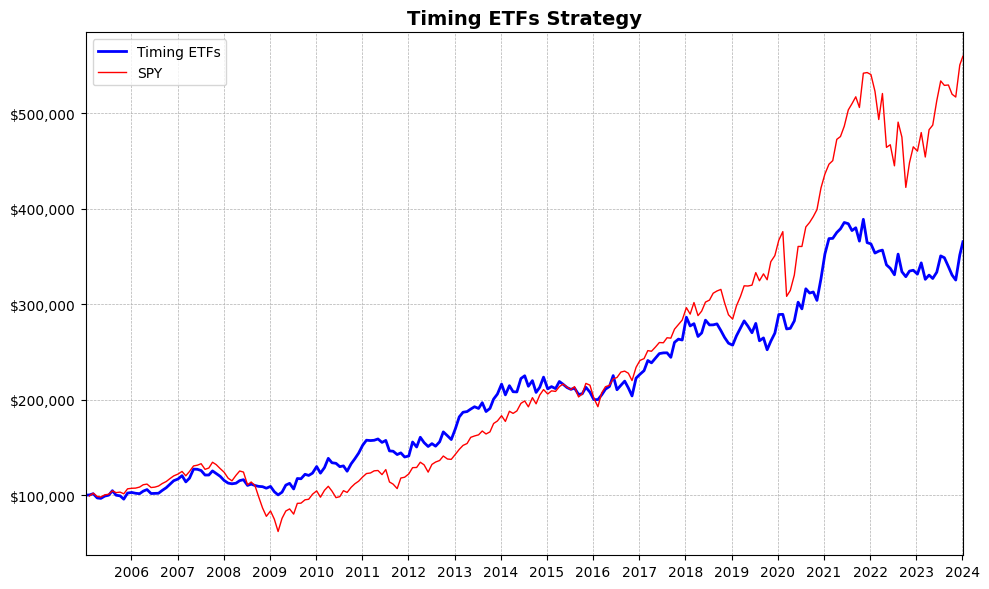

In [69]:
# Ensure 'caldt' is in datetime format
port['caldt'] = pd.to_datetime(port['caldt'])

# Set the frequency for plotting
freq = 21

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the AUM
ax.plot(
    pd.concat([port['caldt'].iloc[::freq], port['caldt'].iloc[[-1]]]),
    pd.concat([port['AUM_'].iloc[::freq], port['AUM_'].iloc[[-1]]]),
    linewidth=2,
    color='b',
    label='Timing ETFs',
)

# Plot the AUM_SPX
ax.plot(
    pd.concat([port['caldt'].iloc[::freq], port['caldt'].iloc[[-1]]]),
    pd.concat([port['AUM_SPY'].iloc[::freq], port['AUM_SPY'].iloc[[-1]]]),
    linewidth=1,
    color='r',
    label='SPY',
)

# Set y-axis to logarithmic scale
# ax.set_yscale('log')

# Set y-axis ticks to double each time
ax.yaxis.set_major_locator(MultipleLocator(100_000))
# ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=[2, 3, 4, 5], numticks=10))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '${:,.0f}'.format(x)))

# Ensure the y-axis labels are visible
ax.tick_params(axis='y', which='major', labelsize=10)
ax.tick_params(axis='y', which='minor', labelsize=8)

# Set x-axis date format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Show x-ticks every 10 years

# Add grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend
ax.legend(loc='upper left', fontsize=10)

# Set title
ax.set_title(f'Timing ETFs Strategy', fontweight='bold', fontsize=14)

# Set x and y limits
ax.set_xlim([port['caldt'].iloc[0], port['caldt'].iloc[-1]])

# Show the plot
plt.tight_layout()
plt.show()